In [417]:
%matplotlib inline

In [418]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qgrid
import seaborn as sns

In [419]:
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, show_toolbar=False)

sns.set()

plt.rcParams['figure.figsize'] = (12, 8)
%config InlineBackend.figure_format='retina'

In [420]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
full_data = [train, test]
train.head()
# qgrid.show_grid(train[['Survived', 'Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked']].head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [421]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [422]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [423]:
for dataset in full_data:
    dataset.Embarked = dataset.Embarked.fillna('S')
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [424]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [425]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [426]:
for dataset in full_data:
    age_avg = dataset.Age.mean()
    age_std = dataset.Age.std()
    age_null_cnt = dataset.Age.isnull().sum()

    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_cnt)
    dataset.Age[np.isnan(dataset.Age)] = age_null_random_list
    dataset.Age = dataset.Age.astype(int)

train['CategoricalAge'] = pd.cut(train.Age, 6)
train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean()

/Users/jeffreyyancey/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,CategoricalAge,Survived
0,"(-0.08, 13.333]",0.591549
1,"(13.333, 26.667]",0.336508
2,"(26.667, 40.0]",0.386431
3,"(40.0, 53.333]",0.405172
4,"(53.333, 66.667]",0.348837
5,"(66.667, 80.0]",0.142857


In [427]:
for dataset in full_data:
    dataset.Fare = dataset.Fare.fillna(train.Fare.median())
    
train['CategoricalFare'] = pd.qcut(train.Fare, 6)
train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean()

,CategoricalFare,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 52.369]",0.417808
5,"(52.369, 512.329]",0.697987


In [428]:
def get_title(name): 
    try:
        return name.split(',')[1].split('.')[0].strip()
    except:
        return ''

for dataset in full_data:
    dataset['Title'] = dataset.Name.apply(get_title)

In [429]:
for dataset in full_data:
    dataset.Title = dataset.Title.replace(['Mlle', 'Ms'], 'Miss')
    dataset.Title = dataset.Title.replace('Mme', 'Mrs')
    

In [430]:
blacklist = [t for t in train.Title.unique() if train.Title[train.Title == t].count() < 10]
try:
    for dataset in full_data:
        dataset.Title = dataset.Title.replace(blacklist, 'Other')
except:
    pass

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


## Clean Data

In [431]:
for dataset in full_data:
    # Age
    dataset.loc[dataset.Age <= 13, 'Age'] = 0
    dataset.loc[(dataset.Age > 13) & (dataset.Age <= 26), 'Age'] = 1
    dataset.loc[(dataset.Age > 26) & (dataset.Age <= 40), 'Age'] = 2
    dataset.loc[(dataset.Age > 40) & (dataset.Age <= 53), 'Age'] = 3
    dataset.loc[(dataset.Age > 53) & (dataset.Age <= 66), 'Age'] = 4
    dataset.loc[dataset.Age > 66, 'Age'] = 5
    
    # Sex
    dataset.Sex = dataset.Sex.map({'female': 0, 'male': 1}).astype(int)
    
    # Title
    dataset.Title = dataset.Title.map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5})
    dataset.Title = dataset.Title.fillna(0)
    
    # Fare
    dataset.loc[dataset.Fare <= 7.775, 'Fare'] = 0
    dataset.loc[(dataset.Fare > 7.775) & (dataset.Fare <= 8.662), 'Fare'] = 1
    dataset.loc[(dataset.Fare > 8.662) & (dataset.Fare <= 14.454), 'Fare'] = 2
    dataset.loc[(dataset.Fare > 14.454) & (dataset.Fare <= 26.0), 'Fare'] = 3
    dataset.loc[(dataset.Fare > 26.0) & (dataset.Fare <= 52.369), 'Fare'] = 4
    dataset.loc[dataset.Fare > 52.369, 'Fare'] = 5
    
    # Embarked
    dataset.Embarked = dataset.Embarked.map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']

train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare', 'FamilySize'], axis=1)

test = test.drop(drop_elements, axis=1)

print train.head(10)

train=train.values
test=test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1   0.0         0        0      1
1         1       1    0    2   5.0         1        0      3
2         1       3    0    1   1.0         0        1      2
3         1       1    0    2   5.0         0        0      3
4         0       3    1    2   1.0         0        1      1
5         0       3    1    2   1.0         2        1      1
6         0       1    1    4   4.0         0        1      1
7         0       3    1    0   3.0         0        0      4
8         1       3    0    2   2.0         0        0      3
9         1       2    0    1   4.0         1        0      3


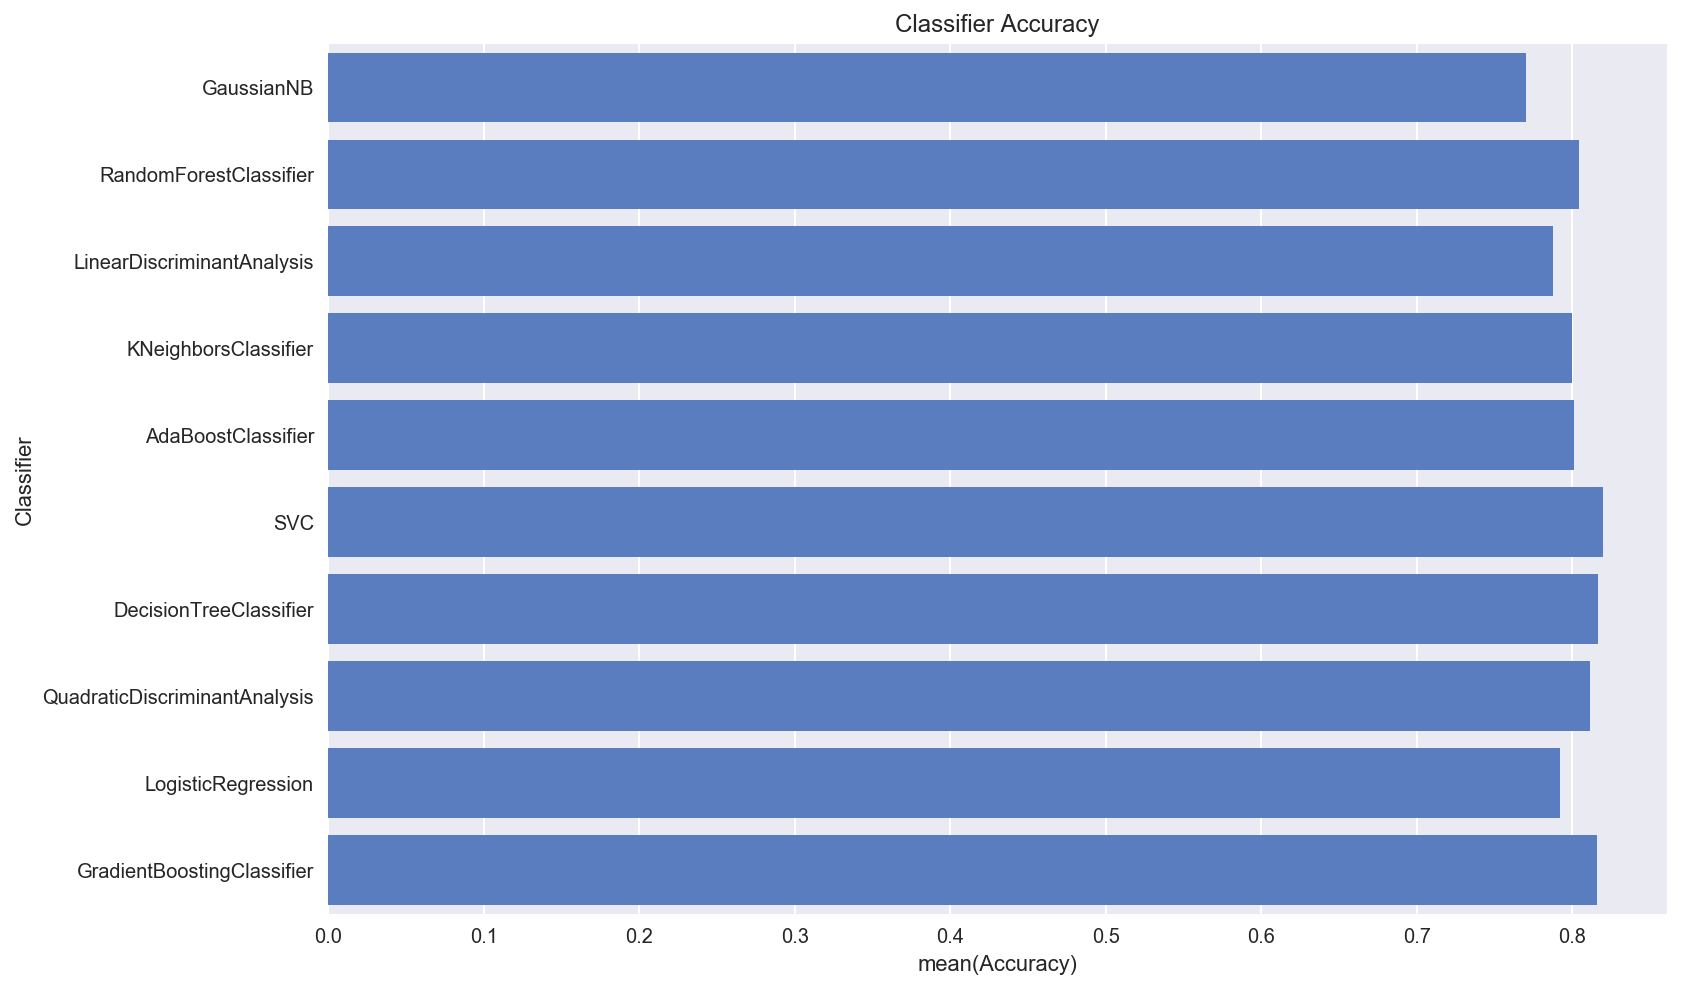

In [432]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [437]:
print train[0]
print test[0]

[ 0.  3.  1.  1.  0.  0.  0.  1.]
[ 3.  1.  2.  1.  2.  1.  1.  1.]
